In [1]:
import sys

sys.path.append('./source/')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate, stats
import matplotlib.cm as cm
from numpy import fft
from scipy import interpolate as intp
import importlib
import healpy

from source import plots
from source import prob_dists as pd
from utils import read_param_file, update_params

In [3]:
param_file = './source/n0.params'
params = read_param_file(param_file)
p = params

exposure = 5 * 14000 / (4 * np.pi)
p = update_params(param_file, p, 'exposure', exposure)

phipp = 7.12073e-30
fwimp = phipp * 8 * np.pi / 1e-28
# fwimp = 1e-4
p = update_params(param_file, p, 'fwimp', fwimp)

p = update_params(param_file, p, 'bg', 1)
p = update_params(param_file, p, 'beg', 1)

print(exposure, fwimp)
p

5570.423008216337 1.7896346444957159


{'R_G': 220,
 'd_solar': 8.5,
 'psi': 40,
 'M_min': 0.01,
 'M_max': 10000000000.0,
 'fwimp': 1.7896346444957159,
 'mean_params': {'a': 77.4, 'b': 0.87, 'c': -0.23},
 'nside': 128,
 'area_fermi': 2000.0,
 'n': 0,
 'log_flux_min': -15,
 'log_flux_max': -5,
 'N': 1000,
 'log_k_min': -3,
 'log_k_max': 6,
 'N_k': 250000,
 'psh_log_f_min': -7,
 'psh_log_f_max': -2.5,
 'N_psh': 1000,
 'omega_pixel': 6.391586616190171e-05,
 'exposure': 5570.423008216337,
 'iso_flux_bg': 0.0008939106670451649,
 'gal_flux_bg_file': './output/gal_flux_bg.npy',
 'bg': 1,
 'beg': 1}

In [4]:
nside = p['nside']
npix = healpy.nside2npix(nside)
lon, lat = healpy.pix2ang(nside, range(npix), lonlat=True)
ang_dists = np.rad2deg(np.arccos(np.cos(np.deg2rad(lon)) * np.cos(np.deg2rad(lat))))
good_indices = (abs(lat) >= 40)

In [5]:
## S-WAVE
s_psh, s_pshfunc2d, s_fluxes, _ = pd.psh_s(ang_dists[good_indices], return_all=True)

## SOM
som_psh, som_pshfunc2d, som_fluxes, _= pd.psh_som(ang_dists[good_indices], return_all=True)

In [6]:
# search parameters
num_search = 75
p['fwimp'] *= 1

fwimps = np.logspace(np.log10(p['fwimp'])-.5, np.log10(p['fwimp'])+.5, num_search)
begs = np.linspace(.9, 1.1, num=75)

exposure_search = np.logspace(0, 1, num=1) * p['exposure']
exposure_search = np.array([1]) * p['exposure']

In [7]:
 def likelihood_run_for_model_2d(psh, fluxes, poisson_rescale=1, model=''):
    # run likelihoods
    s_S = np.zeros((len(exposure_search), len(begs), num_search))
    som_S = np.zeros((len(exposure_search), len(begs), num_search))
    poisson_S = np.zeros((len(exposure_search), len(begs), num_search))

    for i, exposure in enumerate(exposure_search):
        p['exposure'] = exposure

        gal_bg = np.load(p['gal_flux_bg_file'])[good_indices] * p['exposure'] * p['bg']
        iso_bg = p['iso_flux_bg'] * p['exposure'] * p['beg']
        bg_count = gal_bg + iso_bg

        counts = np.arange(0, bg_count.max() + 9 * np.sqrt(bg_count.max()) + p['exposure'] * p['fwimp'] * fluxes.max() + 9 * np.sqrt(p['exposure'] * p['fwimp'] * fluxes.max()))

        print('calculating pc to count =', counts[-1])

        unique_ang, uni_ind, uni_inv = np.unique(np.abs(ang_dists[good_indices]), return_inverse=True, return_index=True)

        pshdat = psh[:, uni_ind]
        psh = pshdat[:, uni_inv]
        if model == 's':
            spsh = pshdat[:, uni_inv]
            sompsh = som_psh
        elif model == 'som':
            sompsh = pshdat[:, uni_inv]
            spsh = s_psh
        else:
            spsh = s_psh
            sompsh = som_psh

        pc_psi = integrate.simps(pshdat[..., np.newaxis] * stats.poisson.pmf(counts[np.newaxis, np.newaxis, :], p['exposure'] * p['fwimp'] * fluxes[:, np.newaxis, np.newaxis]), fluxes, axis=0)
        pc_psi /= np.sum(pc_psi, axis=-1)[:, np.newaxis]

        print('is pc norm', np.allclose(np.sum(pc_psi, axis=-1), 1))
        print('last pc prob', pc_psi[:, -1])

        pc_of_psi = pc_psi[uni_inv]

        # generate sky map
        subcounts = pd.generate_skymap_sample_pc(p, pc_of_psi, ang_dists[good_indices], good_indices, return_subcounts=True, save_output=False, bg_counts=bg_count)

        print('generated skymap with', p['fwimp'])
        print('max counts', counts[-1], subcounts.max())

        for j, beg in enumerate(begs):
            for k, fwimp in enumerate(fwimps):
                S = pd.likelihood2d([exposure, beg, fwimp], spsh, subcounts.astype(np.int16), s_fluxes, eg_bg_count=iso_bg, g_bg_count=gal_bg)
                s_S[i, j, k] = S

                S = pd.likelihood2d([exposure, beg, fwimp/100], sompsh, subcounts.astype(np.int16), som_fluxes, eg_bg_count=iso_bg, g_bg_count=gal_bg)
                som_S[i, j, k] = S

                S = pd.poisson_likelihood2d([exposure, beg, fwimp/poisson_rescale], psh, subcounts.astype(np.int16), fluxes, eg_bg_count=iso_bg, g_bg_count=gal_bg)
                poisson_S[i, j, k] = S

        print(i+1, '/', len(exposure_search))
        
    from scipy.optimize import minimize
    
    indmax = np.unravel_index(np.argmin(s_S, axis=None), s_S.shape)
    s_max = minimize(pd.likelihood2d, [exposure_search[indmax[0]], begs[indmax[1]], fwimps[indmax[2]]], args=(spsh, subcounts.astype(np.int16), s_fluxes, iso_bg, gal_bg), method='Nelder-Mead')
    som_max = minimize(pd.likelihood2d, [exposure_search[indmax[0]], begs[indmax[1]], fwimps[indmax[2]]/100], args=(sompsh, subcounts.astype(np.int16), som_fluxes, iso_bg, gal_bg), method='Nelder-Mead')
    poi_max = minimize(pd.likelihood2d, [exposure_search[indmax[0]], begs[indmax[1]], fwimps[indmax[2]]/poisson_rescale], args=(psh, subcounts.astype(np.int16), fluxes, iso_bg, gal_bg), method='Nelder-Mead')
    
    return [s_S, som_S, poisson_S]

In [8]:
SS = []

SS.append(likelihood_run_for_model_2d(s_psh, s_fluxes, model='s'))
p['fwimp'] /= 100
SS.append(likelihood_run_for_model_2d(som_psh, som_fluxes, model='som', poisson_rescale=100))
p['fwimp'] /= 1e100
SS.append(likelihood_run_for_model_2d(som_psh*1e100, som_fluxes/1e100, model=''))
p['fwimp'] *= 1e102

calculating pc to count = 173.0
is pc norm True
last pc prob [9.40251384e-130 9.49248346e-130 9.40251384e-130 ... 9.49040954e-130
 9.34014791e-130 9.49040954e-130]
generated skymap with 1.7896346444957159
max counts 173.0 64.0
1 / 1
calculating pc to count = 130.0
is pc norm True
last pc prob [0. 0. 0. ... 0. 0. 0.]
generated skymap with 0.01789634644495716
max counts 130.0 66.0
1 / 1
calculating pc to count = 126.0
is pc norm True
last pc prob [0. 0. 0. ... 0. 0. 0.]
generated skymap with 1.7896346444957157e-102
max counts 126.0 67.0
1 / 1


In [9]:
for ss in SS:
    for s in ss:
        indmax = np.unravel_index(np.argmin(s, axis=None), s.shape)
        print(np.amin(s), fwimps[indmax[2]], begs[indmax[1]])

371224.5730774909 1.6816567366585213 1.0
371249.3224992137 0.5659321656152182 1.018918918918919
371249.365247728 3.334530151061592 0.9783783783783784
369140.348305078 0.5659321656152182 1.0081081081081082
369138.5466870404 1.4848524412830082 1.0027027027027027
369140.5305158968 5.154942648453146 0.972972972972973
369247.7378970378 0.5659321656152182 0.9891891891891893
369246.9317546171 0.5659321656152182 0.991891891891892
369246.12079277606 0.5659321656152182 0.9972972972972973


In [10]:
# p['fwimp'] *= 1e12

<ipython-input-14-851a103a06b3>:20: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contourf(fwimps, begs, np.exp(-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s')
<ipython-input-14-851a103a06b3>:13: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contourf(fwimps / 100, begs, np.exp(-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s')
<ipython-input-14-851a103a06b3>:43: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contourf(fwimps, begs, np.exp(-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s')
<ipython-input-14-851a103a06b3>:36: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contourf(fwimps / 100, begs, np.exp(-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s')
<ipython-input-14-851a103a06b3>:66: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contourf(fwimps, begs, np.exp(-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s')
<ipython-input-14-

1.7896346444957156


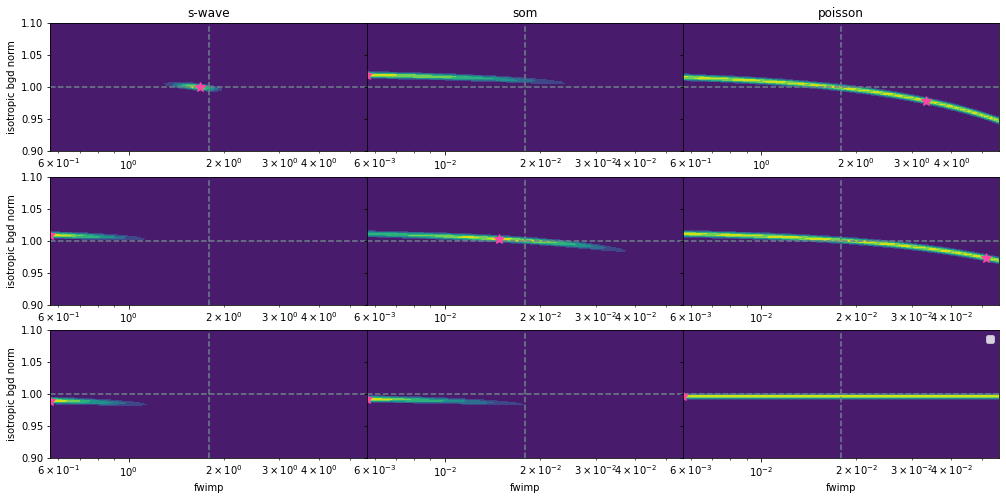

In [14]:
fig, axss = plt.subplots(ncols=3, nrows=3, figsize=(17, 8), sharey=True, gridspec_kw={'wspace': 0})
i = 0
lw = 5
zorder = 1
# p['fwimp'] *= 100
axs = axss[0]

for ax, s, lab in zip(axs, SS[0], ['s-wave L', 'som L', 'poisson L']):
    colors = iter(['xkcd:mulberry', 'xkcd:wheat', 'xkcd:mossy green', 'xkcd:cool blue', 'xkcd:blush pink'])
    for expdat, expo in zip(s, exposure_search):
        indmax = np.unravel_index(np.argmin(expdat, axis=None), expdat.shape)
        if lab == 'som L':
            ax.contourf(fwimps / 100, begs, np.exp(-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s')
            ax.axvline(p['fwimp']/100, ls='--', color='xkcd:steel gray')
            ax.axhline(1, ls='--', color='xkcd:steel gray')
            ax.plot(fwimps[indmax[1]]/100, begs[indmax[0]], marker='*', color='xkcd:barbie pink', ms=10)
#             ax.plot(fwimps/100, expdat - expdat.min(), label=f'{expo:.2}cm2s')
#             print(lab, expdat.min(),  '\t', fwimps[np.exp(-0.5*(expdat - expdat.min())).argmax()]/100)
        else:
            ax.contourf(fwimps, begs, np.exp(-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s')
            ax.axvline(p['fwimp'], ls='--', color='xkcd:steel gray')
            ax.axhline(1, ls='--', color='xkcd:steel gray')
            ax.plot(fwimps[indmax[1]], begs[indmax[0]], marker='*', color='xkcd:barbie pink', ms=10)
#             ax.plot(fwimps, expdat - expdat.min(), label=f'{expo:.2}cm2s')
#             print(lab, expdat.min(),  '\t', fwimps[np.exp(-0.5*(expdat - expdat.min())).argmax()])

    ax.set_xscale('log')
    
axs = axss[1]
# p['fwimp'] /=100
for ax, s, lab in zip(axs, SS[1], ['s-wave L', 'som L', 'poisson L']):
    colors = iter(['xkcd:mulberry', 'xkcd:wheat', 'xkcd:mossy green', 'xkcd:cool blue', 'xkcd:blush pink'])
    for expdat, expo in zip(s, exposure_search):
        indmax = np.unravel_index(np.argmin(expdat, axis=None), expdat.shape)
        if lab == 'som L' or lab == 'poisson L':
            ax.contourf(fwimps / 100, begs, np.exp(-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s')
            ax.axvline(p['fwimp'] / 100, ls='--', color='xkcd:steel gray')
            ax.axhline(1, ls='--', color='xkcd:steel gray')
            ax.plot(fwimps[indmax[1]]/100, begs[indmax[0]], marker='*', color='xkcd:barbie pink', ms=10)
#             ax.plot(fwimps/100, expdat - expdat.min(), label=f'{expo:.2}cm2s')
#             print(lab, expdat.min(),  '\t', fwimps[np.exp(-0.5*(expdat - expdat.min())).argmax()]/100)
        else:
            ax.contourf(fwimps, begs, np.exp(-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s')
            ax.axvline(p['fwimp'], ls='--', color='xkcd:steel gray')
            ax.axhline(1, ls='--', color='xkcd:steel gray')
            ax.plot(fwimps[indmax[1]], begs[indmax[0]], marker='*', color='xkcd:barbie pink', ms=10)
#             ax.plot(fwimps, expdat - expdat.min(), label=f'{expo:.2}cm2s')
#             print(lab, expdat.min(),  '\t', fwimps[np.exp(-0.5*(expdat - expdat.min())).argmax()])

    ax.set_xscale('log')
    
axs = axss[2]
# p['fwimp'] /=100
for ax, s, lab in zip(axs, SS[2], ['s-wave L', 'som L', 'poisson L']):
    colors = iter(['xkcd:mulberry', 'xkcd:wheat', 'xkcd:mossy green', 'xkcd:cool blue', 'xkcd:blush pink'])
    for expdat, expo in zip(s, exposure_search):
        indmax = np.unravel_index(np.argmin(expdat, axis=None), expdat.shape)
        if lab == 'som L' or lab == 'poisson L':
            ax.contourf(fwimps / 100, begs, np.exp(-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s')
            ax.axvline(p['fwimp'] / 100, ls='--', color='xkcd:steel gray')
            ax.axhline(1, ls='--', color='xkcd:steel gray')
            ax.plot(fwimps[indmax[1]]/100, begs[indmax[0]], marker='*', color='xkcd:barbie pink', ms=10)
#             ax.plot(fwimps/100, expdat - expdat.min(), label=f'{expo:.2}cm2s')
#             print(lab, expdat.min(),  '\t', fwimps[np.exp(-0.5*(expdat - expdat.min())).argmax()]/100)
        else:
            ax.contourf(fwimps, begs, np.exp(-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s')
            ax.axvline(p['fwimp'], ls='--', color='xkcd:steel gray')
            ax.axhline(1, ls='--', color='xkcd:steel gray')
            ax.plot(fwimps[indmax[1]], begs[indmax[0]], marker='*', color='xkcd:barbie pink', ms=10)
#             ax.plot(fwimps, expdat - expdat.min(), label=f'{expo:.2}cm2s')
#             print(lab, expdat.min(),  '\t', fwimps[np.exp(-0.5*(expdat - expdat.min())).argmax()])

    ax.set_xscale('log')
# p['fwimp'] *= 100 
for ax in axss[-1]:
    ax.set_xlabel('fwimp')
    
axss[0, 0].set_ylabel('isotropic bgd norm')
axss[1, 0].set_ylabel('isotropic bgd norm')
axss[2, 0].set_ylabel('isotropic bgd norm')

axss[0, 0].set_title('s-wave')
axss[0, 1].set_title('som')
axss[0, 2].set_title('poisson')
    
axss.flatten()[-1].legend()
#     ax.set_yscale('log')
#     ax.set_ylim(bottom=0, top=10)
print(p['fwimp'])
fig.savefig('./output/llhds_2d_fermiexposure.pdf')

Add:
- Float beg but fix bg to 0.97
- Float beg w/ same bg
- Generate w/ no DM signal and fit s/som/poi (null test)
- Add to overleaf
- 

1.983828856376931


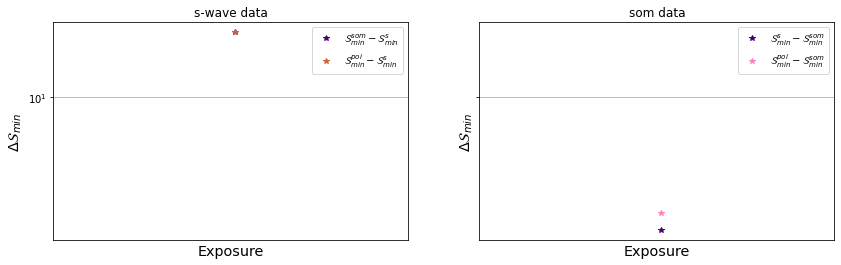

In [12]:
fig, axs = plt.subplots(ncols=2, figsize=(14,4), sharey=True, sharex=True)

ax = axs[0]
s_S, som_S, poisson_S = SS[0]
max_swave = np.amin(s_S)
max_som = np.amin(som_S)
max_poi = np.amin(poisson_S)
ax.plot(exposure_search, -max_swave + max_som, ls='', marker='*', color='xkcd:royal purple', label=r'$\mathcal{S}_{min}^{som} - \mathcal{S}_{min}^{s}$')
ax.plot(exposure_search, -max_swave + max_poi, ls='', marker='*', color='xkcd:terra cotta', label=r'$\mathcal{S}_{min}^{poi} - \mathcal{S}_{min}^{s}$')
# ax.plot(exposure_search, max_som - max_poi, ls='', marker='*', color='xkcd:pink', label=r'$\mathcal{S}_{min}^{som} - \mathcal{S}_{min}^{poi}$')
ax.set_xscale('symlog')
ax.set_yscale('symlog')
ax.grid()
# ax.set_ylim(bottom=10)
ax.set_ylabel(r'$\Delta\mathcal{S}_{min}$', fontsize='x-large')
ax.set_xlabel(r'Exposure', fontsize='x-large')
ax.legend()
 
ax = axs[1]
s_S, som_S, poisson_S = SS[1]
max_swave = np.amin(s_S)
max_som = np.amin(som_S)
max_poi = np.amin(poisson_S)
ax.plot(exposure_search, max_swave - max_som, ls='', marker='*', color='xkcd:royal purple', label=r'$\mathcal{S}_{min}^{s} - \mathcal{S}_{min}^{som}$')
# ax.plot(exposure_search, max_swave - max_poi, ls='', marker='*', color='xkcd:terra cotta', label=r'$\mathcal{S}_{min}^{s} - \mathcal{S}_{min}^{poi}$')
ax.plot(exposure_search, - max_som + max_poi, ls='', marker='*', color='xkcd:pink', label=r'$\mathcal{S}_{min}^{poi} - \mathcal{S}_{min}^{som}$')
ax.set_xscale('symlog')
ax.set_yscale('symlog')
ax.grid()
# ax.set_ylim(bottom=10)
ax.set_ylabel(r'$\Delta\mathcal{S}_{min}$', fontsize='x-large')
ax.set_xlabel(r'Exposure', fontsize='x-large')
ax.legend()
print(max_poi - max_som)
axs[0].set_title('s-wave data')
axs[1].set_title('som data')

fig.savefig('./output/deltaS_2d.pdf')

NameError: name 'mean' is not defined

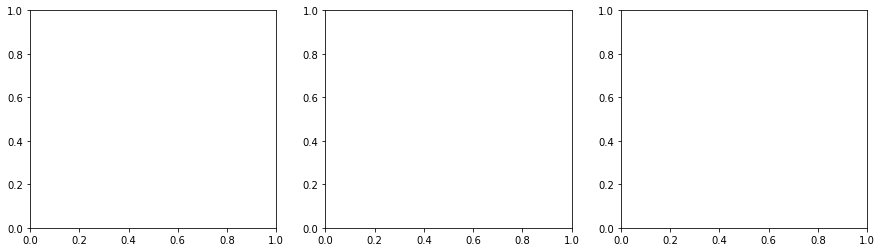

In [13]:
fig, axs = plt.subplots(ncols=3, figsize=(15,4))
axs[0].plot(exposure_search, mean, label='mean', marker='o', ms=10)
axs[0].set_title('mean counts')
axs[1].plot(exposure_search, meanpc, label='P(C) mean', marker='o', ms=10)
axs[1].set_title('mean P(C)')
axs[2].plot(exposure_search, total, label='P(C) mean', marker='o', ms=10)
axs[2].set_title('total counts')

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
# ax.set_ylim(bottom=0, top=)
ax.set_yscale('log')
ax.set_ylabel('Exposure [cm2 s]')
ax.set_xscale('log')
ax.set_xlabel('fwimp')
pc = ax.pcolormesh(fwimps, exposure_search, np.log10(s_S), cmap=cm.jet, shading='auto')
fig.colorbar(pc, label='S for s-wave');

In [ ]:
max_swave = np.amin(s_S, axis=-1)
max_som = np.amin(som_S, axis=-1)
max_poi = np.amin(poisson_S, axis=-1)